# **Nettoyage des données**


In [24]:
!pip install -r requirements.txt

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.graphics.tsaplots as tsaplots

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from scipy import stats #(pour le calcul des fonctions de répartition)
from scipy.signal import savgol_filter

from Codes.scrpits_visualisations import (
    tracer_evolution,
    camembert,
    comparer_periodes
)



Defaulting to user installation because normal site-packages is not writeable


In [25]:
# Importation des données
df = pd.read_excel("Données_produites/base_de_données_v1.xlsx")


# Indexation
df = df.set_index('Unnamed: 0')

#Fonction qui construit un vecteur contenant le nom des variables
def variables_pays(pays):
    variable_pays=[f'CPI_{pays}',f'PIB_{pays}',f'LT_IR_{pays}',f'ST_IR_{pays}',f'WH_{pays}',f'P_Growth_{pays}']
    return(variable_pays)



Etape 1: Eliminer les variables ayant trop de valeurs manquantes

In [26]:
#On élimine l'année 1995 pour éviter de faire du "backcasting" du CPI de tous les pays
df_clean=df.copy()
df_clean=df_clean.drop(["1995-Q1","1995-Q2","1995-Q3","1995-Q4"])

#On élimine l'Estonie de notre dataset
Estonia=variables_pays("Estonia")
df_clean=df_clean.drop(Estonia, axis=1)
df_clean

,CPI_Austria,PIB_Austria,LT_IR_Austria,ST_IR_Austria,WH_Austria,P_Growth_Austria,CPI_Belgium,PIB_Belgium,LT_IR_Belgium,ST_IR_Belgium,...,LT_IR_Switzerland,ST_IR_Switzerland,WH_Switzerland,P_Growth_Switzerland,CPI_United_Kingdom,PIB_United_Kingdom,LT_IR_United_Kingdom,ST_IR_United_Kingdom,WH_United_Kingdom,P_Growth_United_Kingdom
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1996-Q1,71.553333,44641.2,6.396633,3.476667,39.8,2.573010,70.003333,54240.0,6.640000,3.350000,...,4.400333,NaN,37.000,1.317706,68.100000,262343.7,7.753200,6.277534,36.70,3.335283
1996-Q2,71.716667,46885.1,6.505600,3.266667,39.9,2.577419,70.516667,55590.7,6.713333,3.243333,...,4.546000,NaN,37.025,1.373025,68.866667,270422.9,8.067100,6.045267,36.65,3.286445
1996-Q3,71.763333,46969.6,6.430133,3.420000,40.0,2.580149,70.446667,53541.2,6.616667,3.230000,...,4.428000,NaN,37.050,1.426207,68.933333,277865.2,7.851067,5.840597,36.60,3.238139
1996-Q4,72.053333,47418.5,5.953500,3.330000,40.1,2.581239,70.936667,56570.4,6.000000,3.043333,...,4.160666,NaN,37.075,1.477287,69.366667,306097.3,7.569366,6.278986,36.55,3.190366
1997-Q1,72.463333,44369.0,5.709800,3.323333,40.2,2.580730,71.246667,53907.0,5.796667,3.203333,...,3.776333,NaN,37.100,1.526295,69.366667,323587.7,7.401933,6.335840,36.50,3.143125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-Q4,132.593333,122280.3,3.125533,3.957456,32.9,NaN,127.550000,158085.7,3.150000,3.957456,...,0.841333,1.718106,36.300,NaN,NaN,NaN,4.234600,5.326667,35.70,NaN
2024-Q1,133.326667,117154.2,2.835333,3.923615,34.0,NaN,129.700000,147812.8,2.890000,3.923615,...,0.765667,1.628413,35.700,NaN,NaN,NaN,4.029300,5.203333,35.70,NaN
2024-Q2,134.366667,120629.4,3.013533,3.808172,32.9,NaN,131.086667,154840.7,3.063333,3.808172,...,0.722333,1.475667,35.900,NaN,NaN,NaN,4.201500,5.166667,35.70,NaN


In [27]:
# Les données de l'OCDE pour le CPI de la Suisse (méthodologie proche à celle d'Eurostat)
cpi_suisse = pd.read_csv(r"Données_extraites\CPI_Suisse_OCDE.csv")
cpi_suisse = cpi_suisse.pivot_table(index='TIME_PERIOD', columns='Reference area', values='OBS_VALUE')
cpi_suisse = cpi_suisse.drop(cpi_suisse.index[:4])


#On recopie ces données dans df_clean
df_clean['CPI_Switzerland']= cpi_suisse['Switzerland'].values
df_clean


,CPI_Austria,PIB_Austria,LT_IR_Austria,ST_IR_Austria,WH_Austria,P_Growth_Austria,CPI_Belgium,PIB_Belgium,LT_IR_Belgium,ST_IR_Belgium,...,LT_IR_Switzerland,ST_IR_Switzerland,WH_Switzerland,P_Growth_Switzerland,CPI_United_Kingdom,PIB_United_Kingdom,LT_IR_United_Kingdom,ST_IR_United_Kingdom,WH_United_Kingdom,P_Growth_United_Kingdom
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1996-Q1,71.553333,44641.2,6.396633,3.476667,39.8,2.573010,70.003333,54240.0,6.640000,3.350000,...,4.400333,NaN,37.000,1.317706,68.100000,262343.7,7.753200,6.277534,36.70,3.335283
1996-Q2,71.716667,46885.1,6.505600,3.266667,39.9,2.577419,70.516667,55590.7,6.713333,3.243333,...,4.546000,NaN,37.025,1.373025,68.866667,270422.9,8.067100,6.045267,36.65,3.286445
1996-Q3,71.763333,46969.6,6.430133,3.420000,40.0,2.580149,70.446667,53541.2,6.616667,3.230000,...,4.428000,NaN,37.050,1.426207,68.933333,277865.2,7.851067,5.840597,36.60,3.238139
1996-Q4,72.053333,47418.5,5.953500,3.330000,40.1,2.581239,70.936667,56570.4,6.000000,3.043333,...,4.160666,NaN,37.075,1.477287,69.366667,306097.3,7.569366,6.278986,36.55,3.190366
1997-Q1,72.463333,44369.0,5.709800,3.323333,40.2,2.580730,71.246667,53907.0,5.796667,3.203333,...,3.776333,NaN,37.100,1.526295,69.366667,323587.7,7.401933,6.335840,36.50,3.143125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-Q4,132.593333,122280.3,3.125533,3.957456,32.9,NaN,127.550000,158085.7,3.150000,3.957456,...,0.841333,1.718106,36.300,NaN,NaN,NaN,4.234600,5.326667,35.70,NaN
2024-Q1,133.326667,117154.2,2.835333,3.923615,34.0,NaN,129.700000,147812.8,2.890000,3.923615,...,0.765667,1.628413,35.700,NaN,NaN,NaN,4.029300,5.203333,35.70,NaN
2024-Q2,134.366667,120629.4,3.013533,3.808172,32.9,NaN,131.086667,154840.7,3.063333,3.808172,...,0.722333,1.475667,35.900,NaN,NaN,NaN,4.201500,5.166667,35.70,NaN


Etape 2: déterminer des modèles pour nettoyer les données manquantes en début de période 

In [28]:
# Clean values: format time series
df_clean_TS=df_clean.copy()
df_clean_TS.index = pd.PeriodIndex(df_clean.index, freq='Q')  #conversion en PeriodIndex
df_clean_TS.index = df_clean_TS.index.to_timestamp() #Conversion en DateTime

df_clean_TS


,CPI_Austria,PIB_Austria,LT_IR_Austria,ST_IR_Austria,WH_Austria,P_Growth_Austria,CPI_Belgium,PIB_Belgium,LT_IR_Belgium,ST_IR_Belgium,...,LT_IR_Switzerland,ST_IR_Switzerland,WH_Switzerland,P_Growth_Switzerland,CPI_United_Kingdom,PIB_United_Kingdom,LT_IR_United_Kingdom,ST_IR_United_Kingdom,WH_United_Kingdom,P_Growth_United_Kingdom
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1996-01-01,71.553333,44641.2,6.396633,3.476667,39.8,2.573010,70.003333,54240.0,6.640000,3.350000,...,4.400333,NaN,37.000,1.317706,68.100000,262343.7,7.753200,6.277534,36.70,3.335283
1996-04-01,71.716667,46885.1,6.505600,3.266667,39.9,2.577419,70.516667,55590.7,6.713333,3.243333,...,4.546000,NaN,37.025,1.373025,68.866667,270422.9,8.067100,6.045267,36.65,3.286445
1996-07-01,71.763333,46969.6,6.430133,3.420000,40.0,2.580149,70.446667,53541.2,6.616667,3.230000,...,4.428000,NaN,37.050,1.426207,68.933333,277865.2,7.851067,5.840597,36.60,3.238139
1996-10-01,72.053333,47418.5,5.953500,3.330000,40.1,2.581239,70.936667,56570.4,6.000000,3.043333,...,4.160666,NaN,37.075,1.477287,69.366667,306097.3,7.569366,6.278986,36.55,3.190366
1997-01-01,72.463333,44369.0,5.709800,3.323333,40.2,2.580730,71.246667,53907.0,5.796667,3.203333,...,3.776333,NaN,37.100,1.526295,69.366667,323587.7,7.401933,6.335840,36.50,3.143125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01,132.593333,122280.3,3.125533,3.957456,32.9,NaN,127.550000,158085.7,3.150000,3.957456,...,0.841333,1.718106,36.300,NaN,NaN,NaN,4.234600,5.326667,35.70,NaN
2024-01-01,133.326667,117154.2,2.835333,3.923615,34.0,NaN,129.700000,147812.8,2.890000,3.923615,...,0.765667,1.628413,35.700,NaN,NaN,NaN,4.029300,5.203333,35.70,NaN
2024-04-01,134.366667,120629.4,3.013533,3.808172,32.9,NaN,131.086667,154840.7,3.063333,3.808172,...,0.722333,1.475667,35.900,NaN,NaN,NaN,4.201500,5.166667,35.70,NaN


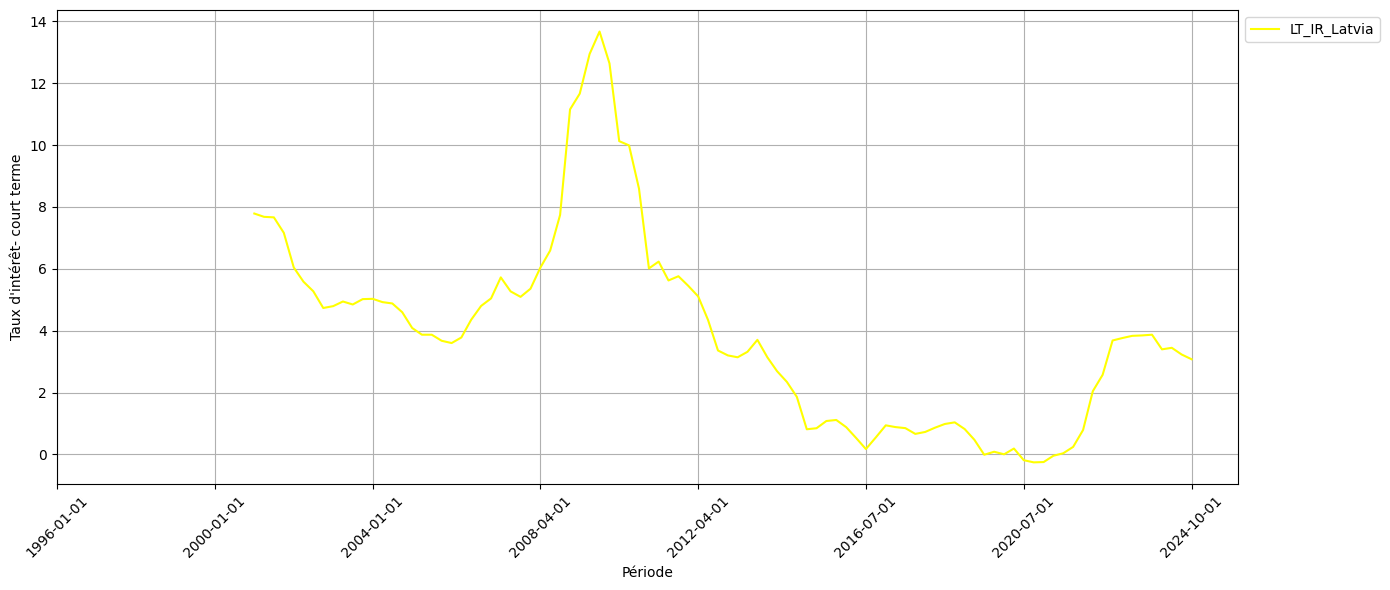

In [29]:
#Le code qui suit sert uniquement à visualiser les ST
# syntaxe: tracer_evolution(df, columns=None, xlabel= None, ylabel=None, start_date=None, end_date=None, log=False, base=None, lissage=False):
tracer_evolution(df_clean_TS,["LT_IR_Latvia"], xlabel ="Période",ylabel = "Taux d'intérêt- court terme")


In [30]:
#Pour le moment la série ne semble avoir ni tendance ni saisonalité, essayons d'appliquer un test ADF
result = adfuller(df_clean_TS["LT_IR_Latvia"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

#La série n'est pas stationnaire
#essayons de faire une différenciatio

ADF Statistic: -1.8849115861464936
p-value: 0.339192126932768


In [31]:
LT_IR_Latvia_diff=df_clean_TS["LT_IR_Latvia"].diff()
#LT_IR_Latvia_diff.plot(title="Taux d'intérêt Lettonie différencié", figsize=(12, 4))

In [33]:
#Résult
result = adfuller(LT_IR_Latvia_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

#On rejette à 5% l'hypothèse de non stationarité


ADF Statistic: -3.1602487301201223
p-value: 0.022404055416099515


<Figure size 1400x600 with 0 Axes>

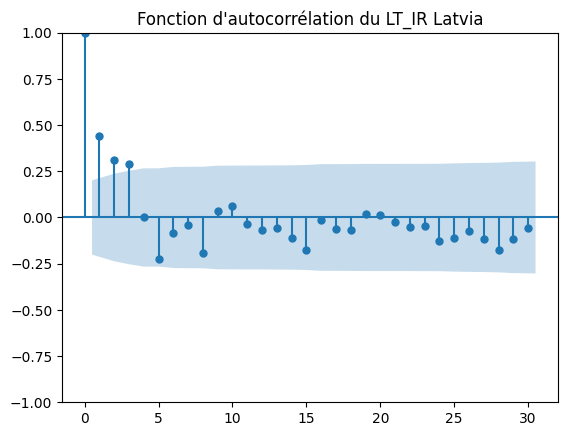

<Figure size 1400x600 with 0 Axes>

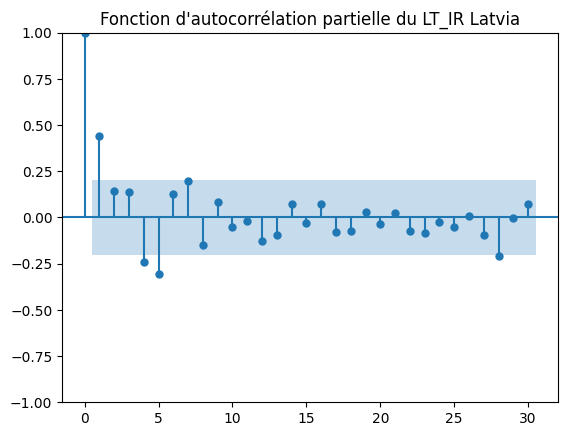

In [34]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(LT_IR_Latvia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du LT_IR Latvia")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(LT_IR_Latvia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du LT_IR Latvia")
plt.show()



In [ ]:
def arimafit(p,q, data, max_lag=15): # je n'ai pas réussi à l'executer depuis le fichier codes (scripts_series_Temp)
    print(f"\n ARIMA({p},0,{q})")
    try:
        #Etape 1: estimation du modèle 
        model=ARIMA(data,order=(p,0,q))
        fit=model.fit()

        coef=fit.params
        std_errors=fit.bse
        t_stats=coef/std_errors
        p_values=2*(1-stats.norm.cdf(np.abs(t_stats)))

        #Résumé
        summary_table=pd.DataFrame({
           'Coef': coef,
           'Std Err': std_errors, 
           't-stat': t_stats,
           'p-value':p_values          
        })

        print("\n Coefficients estimés et p-valeurs")
        print(summary_table.round(4))

        #Etape 2: Tests des résidus
        ljung = acorr_ljungbox(fit.resid, lags=range(1, max_lag + 1), return_df=True)
        print(f"\n Test de Ljung-Box (autocorrélation des résidus jusqu'à {max_lag} lags) : ")
        print(ljung.round(4))

        return {
            'fit': fit,
            'coef_summary': summary_table,
            'ljung_box': ljung
        }
    except Exception as e:
        print(f" Problème pour ARIMA({p},0,{q}): {e}")
        return None

In [42]:
#On choisit donc p=2 et q=4

for p in range(3):      # p = 0, 1, 2, 3
    for q in range(5):  # q = 0, 1, 2
        arimafit(p, q, LT_IR_Latvia_diff.dropna())



 ARIMA(0,0,0)

 Coefficients estimés et p-valeurs
          Coef  Std Err   t-stat  p-value
const  -0.0496   0.0716  -0.6930   0.4883
sigma2  0.4783   0.0312  15.3469   0.0000

 Test de Ljung-Box (autocorrélation des résidus jusqu'à 15 lags) : 
    lb_stat  lb_pvalue
1   19.0601        0.0
2   28.6545        0.0
3   36.9973        0.0
4   36.9999        0.0
5   42.1731        0.0
6   42.9307        0.0
7   43.1096        0.0
8   47.1091        0.0
9   47.2593        0.0
10  47.6603        0.0
11  47.8026        0.0
12  48.3369        0.0
13  48.6701        0.0
14  50.1266        0.0
15  53.7585        0.0

 ARIMA(0,0,1)

 Coefficients estimés et p-valeurs
          Coef  Std Err   t-stat  p-value
const  -0.0499   0.0925  -0.5398   0.5893
ma.L1   0.3642   0.0684   5.3237   0.0000
sigma2  0.4059   0.0347  11.6942   0.0000

 Test de Ljung-Box (autocorrélation des résidus jusqu'à 15 lags) : 
    lb_stat  lb_pvalue
1    0.3853     0.5348
2    5.7017     0.0578
3   10.7220     0.0133
4   10

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 Coefficients estimés et p-valeurs
          Coef  Std Err   t-stat  p-value
const  -0.0595   0.0619  -0.9601   0.3370
ar.L1   1.4096   0.0842  16.7363   0.0000
ar.L2  -0.4554   0.0550  -8.2851   0.0000
ma.L1  -0.9998  14.4117  -0.0694   0.9447
sigma2  0.3684   5.2754   0.0698   0.9443

 Test de Ljung-Box (autocorrélation des résidus jusqu'à 15 lags) : 
    lb_stat  lb_pvalue
1    0.6749     0.4113
2    1.1110     0.5738
3    8.5985     0.0351
4    8.5986     0.0720
5   15.5104     0.0084
6   15.7956     0.0149
7   17.3894     0.0151
8   25.0404     0.0015
9   27.2916     0.0013
10  28.3494     0.0016
11  28.5705     0.0026
12  28.8393     0.0042
13  28.9107     0.0067
14  29.0461     0.0103
15  33.3697     0.0042

 ARIMA(2,0,2)

 Coefficients estimés et p-valeurs
          Coef  Std Err  t-stat  p-value
const  -0.0449   0.1313 -0.3421   0.7323
ar.L1   1.2442   0.2284  5.4477   0.0000
ar.L2  -0.6391   0.1899 -3.3659   0.0008
ma.L1  -0.9747   0.2420 -4.0278   0.0001
ma.L2   0.6972   0.

Pour visualier le nettoyage progressif des fonctions

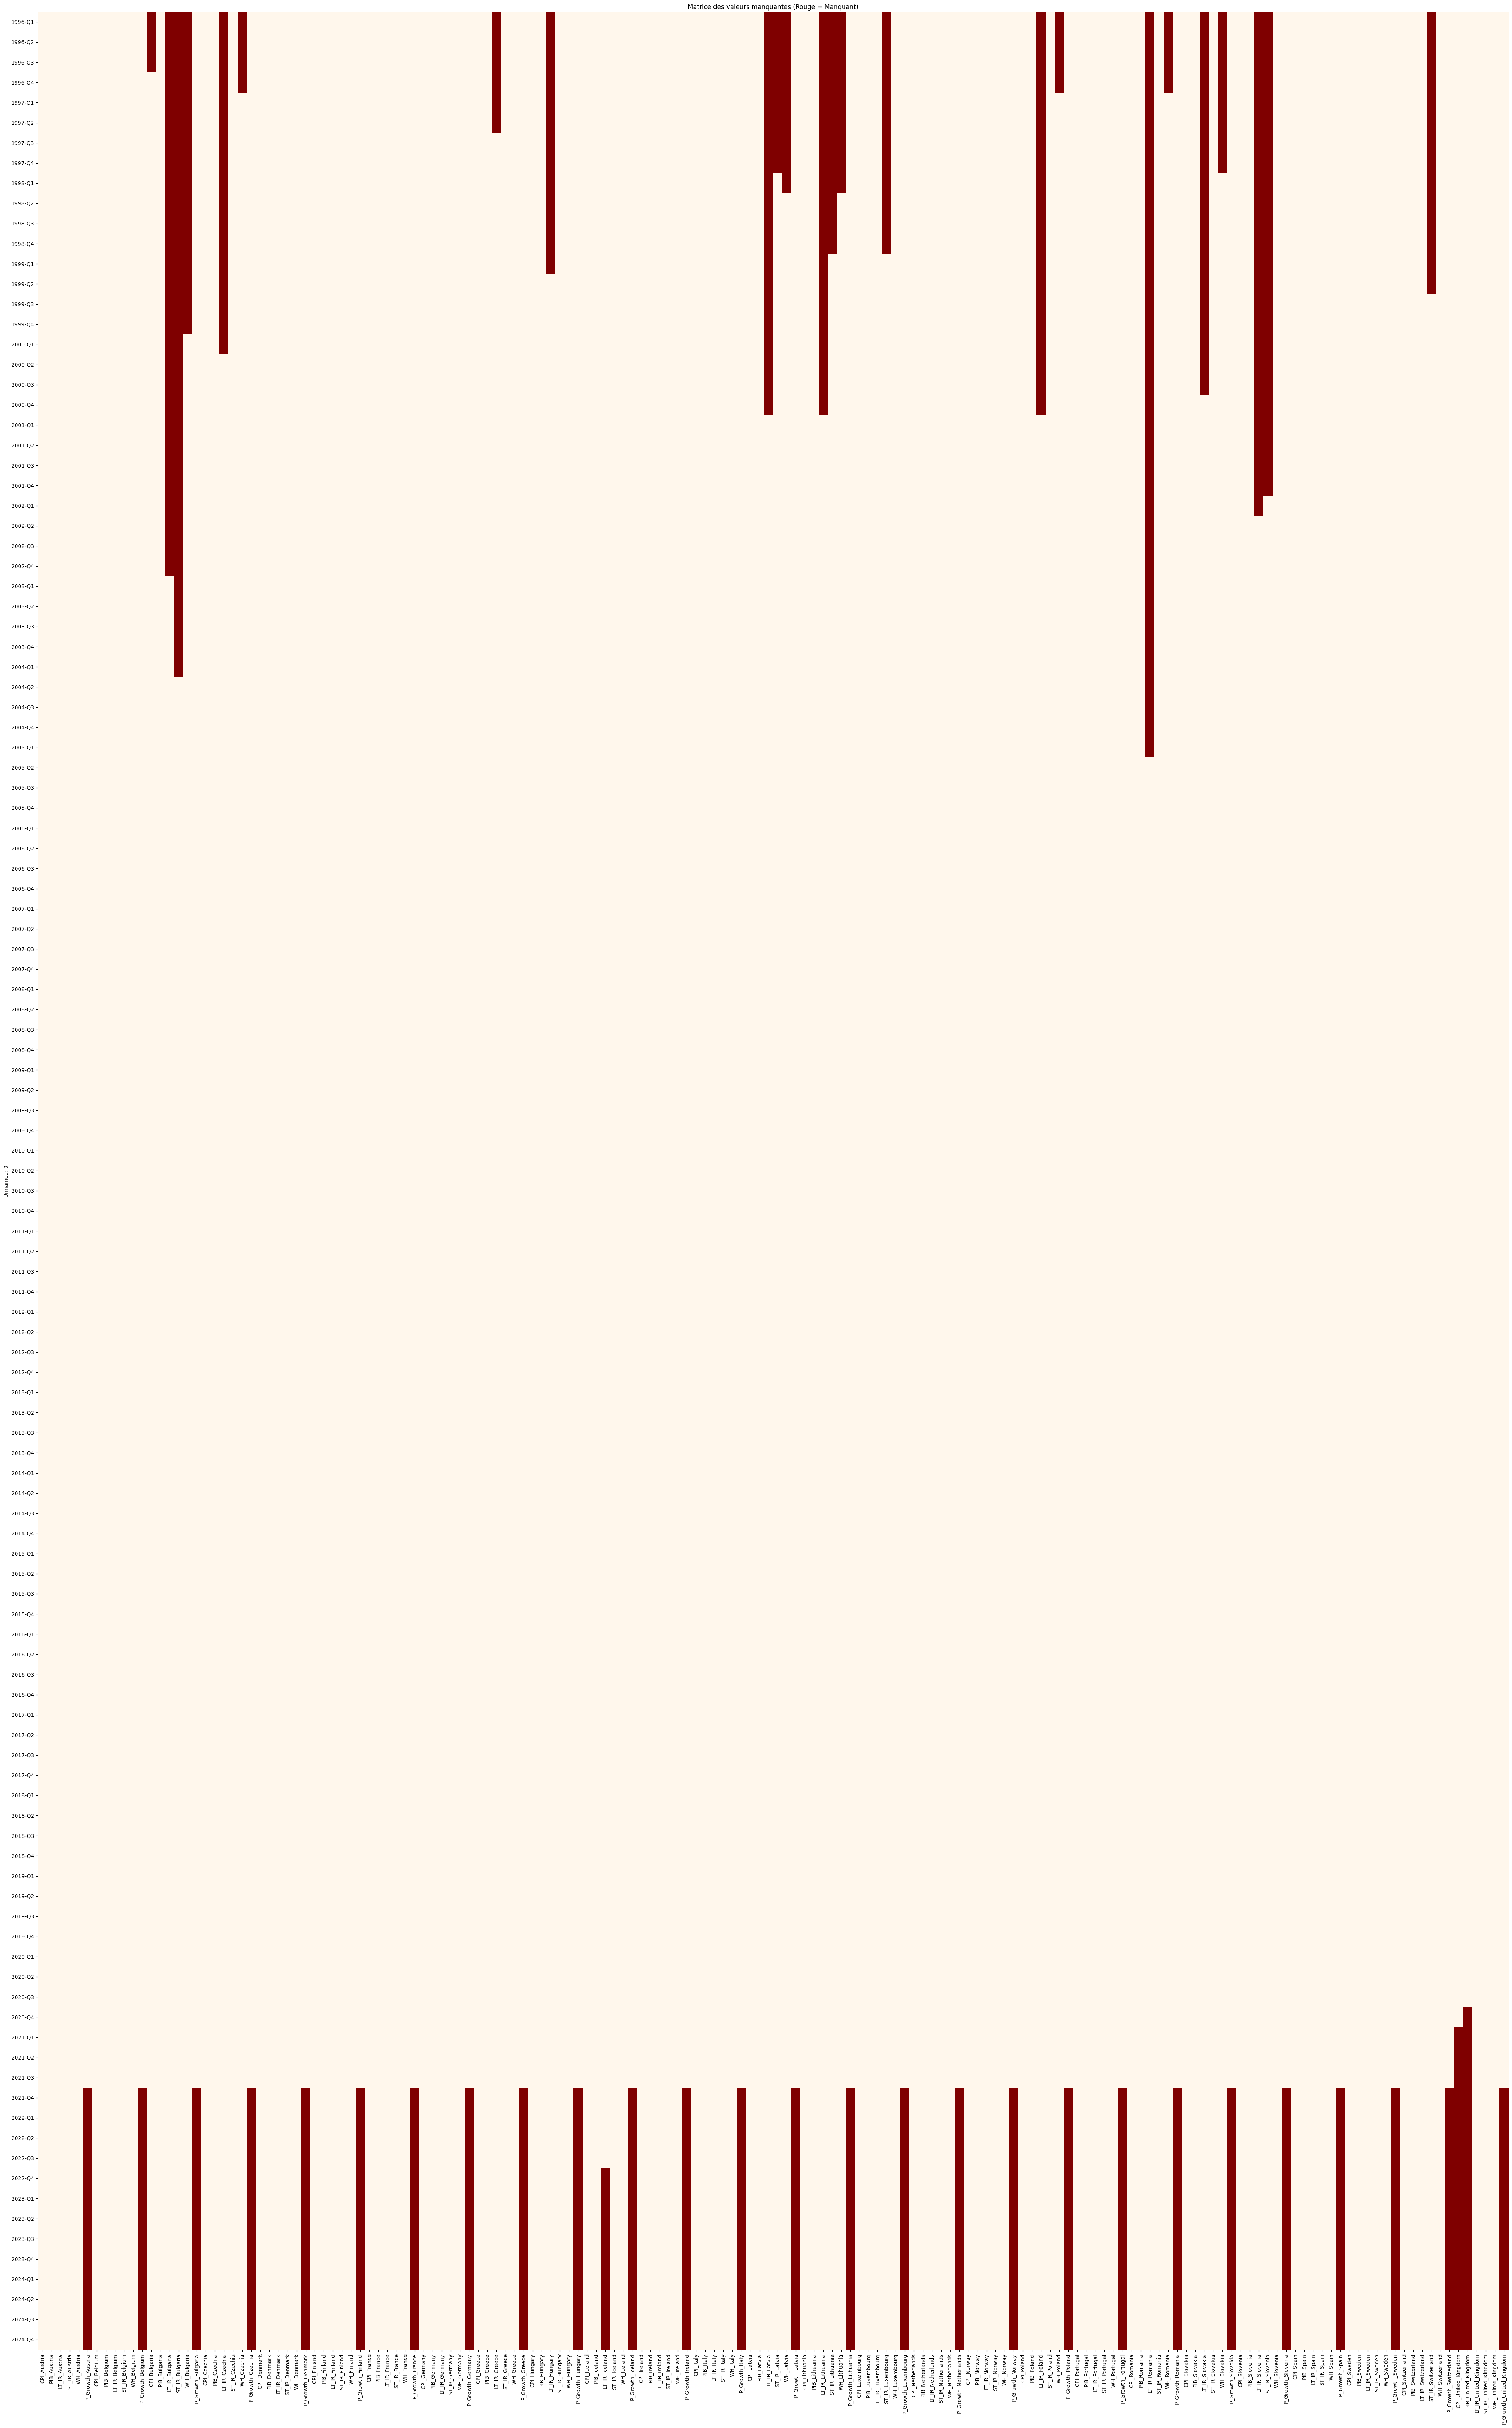

In [36]:
#Pour visualiser le nettoyage progressif des données
df_clean_missing_binary = df_clean.isnull().astype(int)

# Définir la figure avec un affichage interactif
fig, ax = plt.subplots(figsize=(50, 80))

# Utiliser seaborn pour une meilleure visualisation sans grille
sns.heatmap(df_clean_missing_binary, cmap="OrRd", cbar=False, linewidths=0, ax=ax, square=False)

# Ajouter un titre
ax.set_title("Matrice des valeurs manquantes (Rouge = Manquant)")

# Rotation des labels pour une meilleure lisibilité
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Afficher la figure
plt.show()


In [37]:
#Pourcentage de données manquantes par variable
percentage_missing_clean=((df_clean_missing_binary.sum())/df_clean_missing_binary.shape[0])*100

#On ne garde que les colonnes ayant des missing values
percentage_missing_clean=percentage_missing_clean[percentage_missing_clean>0]
percentage_missing_clean = percentage_missing_clean.sort_values(ascending=False)
percentage_missing_clean

LT_IR_Romania              31.896552
ST_IR_Bulgaria             28.448276
LT_IR_Bulgaria             24.137931
LT_IR_Slovenia             21.551724
ST_IR_Slovenia             20.689655
LT_IR_Latvia               17.241379
LT_IR_Lithuania            17.241379
LT_IR_Poland               17.241379
LT_IR_Slovakia             16.379310
PIB_United_Kingdom         14.655172
LT_IR_Czechia              14.655172
WH_Bulgaria                13.793103
CPI_United_Kingdom         13.793103
ST_IR_Switzerland          12.068966
P_Growth_Italy             11.206897
P_Growth_Bulgaria          11.206897
P_Growth_Czechia           11.206897
P_Growth_Denmark           11.206897
P_Growth_France            11.206897
P_Growth_Finland           11.206897
P_Growth_Belgium           11.206897
P_Growth_Austria           11.206897
P_Growth_Sweden            11.206897
P_Growth_Spain             11.206897
P_Growth_Romania           11.206897
P_Growth_Slovenia          11.206897
P_Growth_Iceland           11.206897
P